In [3]:
import os
import time
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from selenium import webdriver
from collections import Counter
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.font_manager as fm
from plotly.subplots import make_subplots
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (
    DateRange,
    Dimension,
    Metric,
    MetricType,
    RunReportRequest,
)

# **초기 설정**

In [4]:
with open('./Data Project/JSON/Tistory-config.json', 'r') as f:
    config = json.load(f)
    
GOOGLE_APPLICATION_CREDENTIALS_ADDRESS = config['GOOGLE_APPLICATION_CREDENTIALS_ADDRESS']
PROPERTY_ID = config['PROPERTY_ID']
BLOG_URL = config['BLOG_URL']
GOOGLE_PAGE_SPEED_API_KEY = config['GOOGLE_PAGE_SPEED_API_KEY']

In [5]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_APPLICATION_CREDENTIALS_ADDRESS

In [6]:
plt.rcParams['font.family'] = 'NanumSquare'
plt.rcParams['axes.unicode_minus'] = False 

# **티스토리 블로그**

**티스토리 블로그 정보 가져오기**
- [티스토리 API]('https://tistory.github.io/document-tistory-apis/') : 2024년 2월부로 API가 중단되었다.
- 웹 스크래핑 : 셀레니움4를 통해 게시글 정보를 가져오기로 했다.


[**셀레니움 공식문서**](https://www.selenium.dev/selenium/docs/api/py/index.html)
- **셀레니움4**부터는 셀레니움에서 필요한 드라이버가 없는 경우, 자동으로 탐색하고 다운로드하기 때문에 *사용자가 별도로 드라이버나 브라우저를 다운로드하여 설정할 필요가 없다.*

**데이터 수집**
- 글 목록에서 **path, 제목, 카테고리, 날짜 정보**를 수집한다.
- 날짜 정보 같은 경우, **년/월/일** 정보만 얻을 수 있어서 게시글에 있는 **날짜, 시간** 정보를 수집하기로 했다.

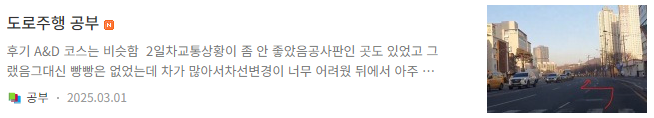

**문제1** : 수익화 블로그였기 때문에 스크래핑 중 광고로 인해 원활하게 창 전환이 안되는 문제가 있었다.
- try1(실패) : 광고 영역부분에서 닫기를 시도했는데 태그가 인식되지 않았다. (나중에 확인해볼 것)
- try2(실패) : 새로고침을 하면 광고가 사라져서 `brower.refresh()`로 해결
<br>  → 새로고침하면 이전에 참조했던 요소가 유효하지 않기 때문에 다시 요소를 참조해야 한다.
- try3(성공) : path를 받아와서 이동 후 date 정보를 추출
---
**문제2** : 글목록에서 '더보기' 버튼을 누른 후, `time.sleep(5)`을 준 상태에서 데이터를 추출시도해도 누락되는 경우가 발생했다.
- try1(성공): 게시글에서 정보를 추출하기로 했다.

In [ ]:
browser = webdriver.Chrome()
browser.get(BLOG_URL)

data = []

flag = True
while flag:
    try:
        browser.find_element(By.CLASS_NAME, 'area-paging-more').click()
    except:
        print("하한선에 도달")
        flag = False

time.sleep(5)
article = browser.find_elements(By.CLASS_NAME, 'article-type-common')
for item in article:
    time.sleep(2)
    path = item.find_element(By.CLASS_NAME, "link-article").get_attribute("href")

    browser.execute_script("window.open(arguments[0]);", path)
    browser.switch_to.window(browser.window_handles[1])

    try:
        post = WebDriverWait(browser, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'box-meta'))
        )
        title = post.find_element(By.CLASS_NAME, 'title-article').text
        category = post.find_element(By.CLASS_NAME, 'category').text
        date = post.find_element(By.CLASS_NAME, 'date').text
    except:
        date = "N/A"

    data.append([path, title, category, date])

    browser.close()
    browser.switch_to.window(browser.window_handles[0])
#print(data)

- 멀티미디어 개수 확인 (이미지, gif, 동영상)

In [163]:
browser = webdriver.Chrome()
browser.get(BLOG_URL)

data = [] # .article-view img

flag = True
while flag:
    try:
        browser.find_element(By.CLASS_NAME, 'area-paging-more').click()
    except:
        print("하한선에 도달")
        flag = False

time.sleep(5)
article = browser.find_elements(By.CLASS_NAME, 'article-type-common')
for item in article:
    time.sleep(2)
    path = item.find_element(By.CLASS_NAME, "link-article").get_attribute("href")
    path = "/" + path.replace(BLOG_URL, '')
    
    browser.execute_script("window.open(arguments[0]);", path)
    browser.switch_to.window(browser.window_handles[1])

    try:
        post = WebDriverWait(browser, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'article-view'))
        )
        imgs = post.find_elements(By.TAG_NAME, 'img')
        img_file_format = [img.get_attribute('src').split(".")[-1] for img in imgs]
        imgs_count = Counter(img_file_format)['png'] + Counter(img_file_format)['jpg'] + Counter(img_file_format)['webp']
        gif_count = Counter(img_file_format)['gif']
        
        video_count = len(post.find_elements(By.CLASS_NAME, 'player'))
    except Exception as e:
        print(f"예외가 발생했습니다: {e}")
        

    data.append([path, imgs_count, gif_count, video_count])

    browser.close()
    browser.switch_to.window(browser.window_handles[0])
print(data)

하한선에 도달
[['/63', 24, 0, 0], ['/65', 7, 0, 0], ['/61', 8, 0, 0], ['/60', 20, 0, 0], ['/59', 25, 0, 0], ['/58', 11, 1, 0], ['/56', 8, 0, 0], ['/55', 14, 0, 0], ['/54', 14, 0, 0], ['/53', 24, 0, 0], ['/52', 56, 0, 0], ['/48', 7, 0, 0], ['/51', 8, 0, 0], ['/45', 14, 0, 0], ['/50', 3, 0, 0], ['/49', 5, 0, 0], ['/44', 23, 0, 0], ['/43', 5, 0, 0], ['/47', 17, 2, 0], ['/46', 4, 0, 0], ['/42', 5, 0, 0], ['/41', 3, 0, 0], ['/40', 7, 3, 0], ['/39', 24, 0, 0], ['/35', 4, 0, 0], ['/37', 20, 2, 0], ['/34', 5, 1, 0], ['/33', 5, 2, 0], ['/32', 2, 1, 0], ['/29', 10, 1, 0], ['/16', 3, 1, 0], ['/17', 8, 1, 0], ['/15', 6, 1, 0], ['/10', 5, 1, 0], ['/6', 23, 1, 0], ['/5', 17, 1, 0], ['/3', 26, 0, 0], ['/2', 38, 1, 0]]


In [155]:
browser.quit()

## **데이터 확인**

- posts_df : 블로그 게시글에 대한 dataframe
- img_df : 이미지 개수에 대한 dataframe

In [ ]:
posts_df = pd.DataFrame(data, columns=['URL', '제목', '카테고리', "날짜"])
posts_df.head(5)

In [ ]:
posts_df.info()

In [ ]:
#posts_df.describe()

In [164]:
img_df = pd.DataFrame(data, columns=['경로', '이미지 수', 'gif 수', '동영상 수'])
img_df.head(5)

,Path,이미지 수,gif 수,동영상 수
0,/63,24,0,0
1,/65,7,0,0
2,/61,8,0,0
3,/60,20,0,0
4,/59,25,0,0


## **데이터 전처리**

- 결측치 없음

In [112]:
df.isnull().sum()

카테고리    0
날짜      0
경로      0
dtype: int64

### **데이터 타입 변환**

In [94]:
posts_df["날짜"] = pd.to_datetime(posts_df["날짜"])

### **파생 변수 생성**

In [ ]:
df['경로'] = df['URL'].str.replace(BLOG_URL, '')

### **카테고리**
- 블로그 카테고리 생성 때 아이콘과 같이 표시했는데 카테고리명만 추출
- '🎨 전시회 | 박물관', '🎤 콘서트 | 뮤지컬' 카테고리 같은 경우, '박물관', '뮤지컬'만 추출되는데 추후에 영화 카테고리와 함께 '문화생활'로 통합

In [114]:
df["카테고리"] = df["카테고리"].str.split(' ').str[-1]
df.loc[df["카테고리"].isin(["박물관", "뮤지컬", "영화"]), "카테고리"] = "문화생활"
df.head(5)

,카테고리,날짜,경로
0,식당,2024-05-14 15:30:00,/58
1,카페,2024-05-13 11:00:00,/56
2,문화생활,2024-05-08 11:20:00,/55
3,카페,2024-05-06 14:07:00,/54
4,카페,2024-05-06 11:00:00,/53


## **데이터 저장 및 불러오기**

In [292]:
posts_df.to_csv('./Data Project/Data/Tistory_posts.csv', index=False)

In [7]:
posts_df = pd.read_csv('./Data Project/Data/Tistory_posts.csv')
posts_df.head(5)

,카테고리,날짜,경로
0,식당,2024-05-14 15:30:00,/58
1,카페,2024-05-13 11:00:00,/56
2,문화생활,2024-05-08 11:20:00,/55
3,카페,2024-05-06 14:07:00,/54
4,카페,2024-05-06 11:00:00,/53


# **Google Analaytics4** 

- [Google Analaytics4 API 문서](https://developers.google.com/analytics/devguides/reporting/data/v1/api-schema?hl=ko)
- API를 활용해서 필요한 데이터를 수집

In [8]:
def run_report(start_date, end_date, dimensions, metrics, property_id=PROPERTY_ID):
    """Runs a report of active users grouped by country."""
    client = BetaAnalyticsDataClient()

    request = RunReportRequest(
        property=f"properties/{property_id}",
        dimensions=dimensions,
        metrics=metrics,
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )
    response = client.run_report(request)
    return response


def convert_to_dataframe(response):
    data = []
    columns = []

    for dimensionHeader in response.dimension_headers:
        columns.append(dimensionHeader.name)
    for metricHeader in response.metric_headers:
        columns.append(metricHeader.name)
        
    for row in response.rows:
        row_data = []
        for dimension_value in row.dimension_values:
            row_data.append(dimension_value.value)

        for metric_value in row.metric_values:
            row_data.append(metric_value.value)

        data.append(row_data)

    df = pd.DataFrame(data, columns=columns)
    return df

- Dimesions (측정기준) : 경로, 방문날짜시간
- Metrics (측정항목) : 조회수, 총 참여 시간, 활성 사용자, 참여율, 참여 세션수

In [39]:
start_date = '2024-03-01'
end_date = '2024-05-27'
dimensions = [Dimension(name="pagePath"), Dimension(name="dateHour")]
metrics=[Metric(name="screenPageViews"), Metric(name="userEngagementDuration"), Metric(name="activeUsers"), Metric(name="engagementRate"), Metric(name="engagedSessions")]

In [40]:
response = run_report(start_date, end_date, dimensions, metrics)
visiting_time_df = convert_to_dataframe(response)
visiting_time_df.head(5)

,pagePath,dateHour,screenPageViews,userEngagementDuration,activeUsers,engagementRate,engagedSessions
0,/47,2024042220,23,204,8,0.25,2
1,/57,2024051701,18,65,1,1,1
2,/37,2024032222,14,565,1,1,1
3,/47,2024051501,13,1,2,1,2
4,/47,2024042214,11,116,2,0.66666666666666663,2


In [45]:
visiting_time_df = visiting_time_df.rename(columns = {"pagePath":"경로", "dateHour":"방문날짜시간", "screenPageViews" : "조회수", "userEngagementDuration" : "총 참여 시간", 
                          "activeUsers" : "활성 사용자", "engagementRate" : "참여율", "engagedSessions" : "참여 세션수"})

In [46]:
visiting_time_df["방문날짜"] = visiting_time_df["방문날짜시간"].str.slice(0, 8)
visiting_time_df["방문시간"] = visiting_time_df["방문날짜시간"].str.slice(-2)

In [47]:
visiting_time_df = visiting_time_df.astype({'조회수':'int','총 참여 시간':'int', '활성 사용자':'int', '참여율':'float', '참여 세션수' : 'int', "방문날짜" : "datetime64[ns]", "방문시간" : "int"})

In [48]:
visiting_time_df.head(5)

,경로,방문날짜시간,조회수,총 참여 시간,활성 사용자,참여율,참여 세션수,방문날짜,방문시간
0,/47,2024042220,23,204,8,0.250000,2,2024-04-22,20
1,/57,2024051701,18,65,1,1.000000,1,2024-05-17,1
2,/37,2024032222,14,565,1,1.000000,1,2024-03-22,22
3,/47,2024051501,13,1,2,1.000000,2,2024-05-15,1
4,/47,2024042214,11,116,2,0.666667,2,2024-04-22,14


----

- Dimesions (측정기준) : 경로
- Metrics (측정항목) : 조회수, 총 참여 시간, 활성 사용자, 참여율, 참여 세션수

In [197]:
start_date = '2024-03-01'
end_date = '2024-05-27'
dimensions = [Dimension(name="pagePath")]
metrics=[Metric(name="screenPageViews"), Metric(name="userEngagementDuration"), Metric(name="activeUsers"), Metric(name="engagementRate"), Metric(name="engagedSessions")]

In [198]:
response = run_report(start_date, end_date, dimensions, metrics)
ga_df = convert_to_dataframe(response)
ga_df.head(5)

,pagePath,screenPageViews,userEngagementDuration,activeUsers,engagementRate,engagedSessions
0,/47,248,10452,150,0.5617977528089888,100
1,/52,239,4366,208,0.44186046511627908,95
2,/54,178,3124,148,0.51851851851851849,84
3,/53,150,2640,134,0.53623188405797106,74
4,/56,137,4813,123,0.62015503875968991,80


In [199]:
ga_df = ga_df.rename(columns = {"pagePath":"경로", "screenPageViews" : "조회수", "userEngagementDuration" : "총 참여 시간", 
                          "activeUsers" : "활성 사용자", "engagementRate" : "참여율", "engagedSessions" : "참여 세션수"})

In [200]:
ga_df = ga_df.astype({'조회수':'int','총 참여 시간':'int', '활성 사용자':'int', '참여율':'float', '참여 세션수' : 'int'})

In [201]:
ga_df.head(5)

,경로,조회수,총 참여 시간,활성 사용자,참여율,참여 세션수
0,/47,248,10452,150,0.561798,100
1,/52,239,4366,208,0.441860,95
2,/54,178,3124,148,0.518519,84
3,/53,150,2640,134,0.536232,74
4,/56,137,4813,123,0.620155,80


---

- Dimesions (측정기준) : 경로, 방문날짜
- Metrics (측정항목) : 조회수, 총 참여 시간, 활성 사용자, 참여율, 참여 세션수

In [183]:
start_date = '2024-03-01'
end_date = '2024-05-27'
dimensions = [Dimension(name="pagePath"), Dimension(name="date")]
metrics=[Metric(name="screenPageViews"), Metric(name="userEngagementDuration"), Metric(name="activeUsers"), Metric(name="engagementRate"), Metric(name="engagedSessions")]

In [184]:
response = run_report(start_date, end_date, dimensions, metrics)
ga_df = convert_to_dataframe(response)
ga_df.head(5)

,pagePath,date,screenPageViews,userEngagementDuration,activeUsers,engagementRate,engagedSessions
0,/47,20240422,50,506,13,0.41176470588235292,7
1,/47,20240424,35,2989,22,0.34615384615384615,9
2,/54,20240506,35,418,20,0.5,11
3,/53,20240506,31,601,25,0.64,16
4,/55,20240508,30,5028,30,0.78125,25


In [185]:
ga_df = ga_df.rename(columns = {"pagePath":"경로", "date":"방문날짜", "screenPageViews" : "조회수", "userEngagementDuration" : "총 참여 시간", 
                          "activeUsers" : "활성 사용자", "engagementRate" : "참여율", "engagedSessions" : "참여 세션수"})

In [186]:
ga_df = ga_df.astype({'조회수':'int','총 참여 시간':'int', '활성 사용자':'int', '참여율':'float', '참여 세션수' : 'int', "방문날짜" : "datetime64[ns]"})

In [187]:
ga_df.head(5)

,경로,방문날짜,조회수,총 참여 시간,활성 사용자,참여율,참여 세션수
0,/47,2024-04-22,50,506,13,0.411765,7
1,/47,2024-04-24,35,2989,22,0.346154,9
2,/54,2024-05-06,35,418,20,0.500000,11
3,/53,2024-05-06,31,601,25,0.640000,16
4,/55,2024-05-08,30,5028,30,0.781250,25


---

- Dimesions (측정기준) : 경로, 방문날짜
- Metrics (측정항목) : 조회수, 총 참여 시간, 활성 사용자, 참여율, 참여 세션수

In [9]:
start_date = '2024-03-01'
end_date = '2024-05-27'
dimensions = [Dimension(name="pagePath"), Dimension(name="date")]
metrics=[Metric(name="screenPageViews"), Metric(name="userEngagementDuration"), Metric(name="activeUsers"), Metric(name="engagementRate"), Metric(name="engagedSessions")]

In [10]:
response = run_report(start_date, end_date, dimensions, metrics)
ga_df = convert_to_dataframe(response)
ga_df.head(5)

,pagePath,date,screenPageViews,userEngagementDuration,activeUsers,engagementRate,engagedSessions
0,/47,20240422,50,506,13,0.41176470588235292,7
1,/47,20240424,35,2989,22,0.34615384615384615,9
2,/54,20240506,35,418,20,0.5,11
3,/53,20240506,31,601,25,0.64,16
4,/55,20240508,30,5028,30,0.78125,25


In [11]:
ga_df = ga_df.rename(columns = {"pagePath":"경로", "date":"방문날짜", "screenPageViews" : "조회수", "userEngagementDuration" : "총 참여 시간", 
                          "activeUsers" : "활성 사용자", "engagementRate" : "참여율", "engagedSessions" : "참여 세션수"})

In [12]:
ga_df = ga_df.astype({'조회수':'int','총 참여 시간':'int', '활성 사용자':'int', '참여율':'float', '참여 세션수' : 'int', "방문날짜" : "datetime64[ns]"})

---

- Dimesions (측정기준) : 경로, 방문날짜
- Metrics (측정항목) : 총 참여 시간, scroll 이벤트

In [27]:
start_date = '2024-03-01'
end_date = '2024-05-27'
dimensions = [Dimension(name="pagePath"), Dimension(name="percentScrolled")]
metrics=[Metric(name="userEngagementDuration"), Metric(name="activeUsers")]

In [28]:
response = run_report(start_date, end_date, dimensions, metrics)
scroll_ga_df = convert_to_dataframe(response)
scroll_ga_df.head()

,pagePath,percentScrolled,userEngagementDuration,activeUsers
0,/55,90,11200,67
1,/47,,8292,150
2,/56,,3933,123
3,/52,90,2676,56
4,/54,,2266,147


In [29]:
scroll_ga_df = scroll_ga_df.rename(columns = {"pagePath":"경로", "percentScrolled":"스크롤 비율", "userEngagementDuration" : "총 참여 시간", 
                          "activeUsers" : "활성 사용자"})

In [30]:
scroll_ga_df["스크롤 비율"] = scroll_ga_df["스크롤 비율"].replace('', 0)

In [31]:
scroll_ga_df = scroll_ga_df.astype({'스크롤 비율':'int', '총 참여 시간':'int', '활성 사용자':'int', '총 참여 시간':'int'})

In [32]:
scroll_ga_df.head(5)

,경로,스크롤 비율,총 참여 시간,활성 사용자
0,/55,90,11200,67
1,/47,0,8292,150
2,/56,0,3933,123
3,/52,90,2676,56
4,/54,0,2266,147


---

In [11]:
ga_df.to_csv('./Data Project/Data/Google Analytics.csv', index=False)

In [7]:
ga_df = pd.read_csv('./Data Project/Data/Google Analytics.csv')
ga_df.head(5)

,경로,방문날짜,조회수,총 참여 시간,활성 사용자,참여율,참여 세션수
0,/47,2024-04-22,50,506,13,0.411765,7
1,/47,2024-04-24,35,2989,22,0.346154,9
2,/54,2024-05-06,35,418,20,0.500000,11
3,/53,2024-05-06,31,601,25,0.640000,16
4,/55,2024-05-08,30,5028,30,0.781250,25


In [8]:
ga_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   경로       445 non-null    object 
 1   방문날짜     445 non-null    object 
 2   조회수      445 non-null    int64  
 3   총 참여 시간  445 non-null    int64  
 4   활성 사용자   445 non-null    int64  
 5   참여율      445 non-null    float64
 6   참여 세션수   445 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 24.5+ KB


# **데이터프레임 합치기**

In [13]:
df = posts_df.merge(ga_df, on='경로')
df.head()

,카테고리,날짜,경로,방문날짜,조회수,총 참여 시간,활성 사용자,참여율,참여 세션수
0,식당,2024-05-14 15:30:00,/58,2024-05-14,13,201,6,0.166667,1
1,식당,2024-05-14 15:30:00,/58,2024-05-16,4,16,4,0.500000,2
2,식당,2024-05-14 15:30:00,/58,2024-05-17,4,0,3,0.000000,0
3,식당,2024-05-14 15:30:00,/58,2024-05-18,4,50,4,0.500000,2
4,식당,2024-05-14 15:30:00,/58,2024-05-24,3,9,2,1.000000,2


In [35]:
visting_time_df = posts_df.merge(visting_time_df, on='경로')
visting_time_df.head()

,카테고리,날짜,경로,방문날짜시간,조회수,총 참여 시간,활성 사용자,참여율,참여 세션수,방문날짜,방문시간
0,식당,2024-05-14 15:30:00,/58,2024051415,8,201,1,1.0,1,2024-05-14,15
1,식당,2024-05-14 15:30:00,/58,2024051416,4,0,4,0.0,0,2024-05-14,16
2,식당,2024-05-14 15:30:00,/58,2024052418,3,9,2,1.0,2,2024-05-24,18
3,식당,2024-05-14 15:30:00,/58,2024051819,2,10,2,0.0,0,2024-05-18,19
4,식당,2024-05-14 15:30:00,/58,2024051923,2,0,2,0.0,0,2024-05-19,23


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   카테고리     416 non-null    object        
 1   날짜       416 non-null    object        
 2   경로       416 non-null    object        
 3   방문날짜     416 non-null    datetime64[ns]
 4   조회수      416 non-null    int32         
 5   총 참여 시간  416 non-null    int32         
 6   활성 사용자   416 non-null    int32         
 7   참여율      416 non-null    float64       
 8   참여 세션수   416 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(4), object(3)
memory usage: 22.9+ KB


---

In [84]:
scroll_df = posts_df.merge(scroll_ga_df, on='경로')
scroll_df.head(5)

,카테고리,날짜,경로,스크롤 비율,총 참여 시간,활성 사용자
0,식당,2024-05-14 15:30:00,/58,90,191,5
1,식당,2024-05-14 15:30:00,/58,0,182,29
2,카페,2024-05-13 11:00:00,/56,0,3933,123
3,카페,2024-05-13 11:00:00,/56,90,880,16
4,문화생활,2024-05-08 11:20:00,/55,90,11200,67


In [34]:
scroll_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   카테고리     63 non-null     object
 1   날짜       63 non-null     object
 2   경로       63 non-null     object
 3   스크롤 비율   63 non-null     int32 
 4   총 참여 시간  63 non-null     int32 
 5   활성 사용자   63 non-null     int32 
dtypes: int32(3), object(3)
memory usage: 2.3+ KB


## **파생 변수 생성**

- 평균 참여 시간 : 웹사이트 또는 앱이 사용자 기기에서 포그라운드 상태로 있었던 총 시간 (초)

In [51]:
#df["평균 참여 시간(초)"] = (df["총 참여 시간"] / df["활성 사용자"]).apply(np.trunc)
df["전체 세션수"] = df["참여 세션수"] / df["참여율"]

## **결측치 제거**

- 파생변수를 생성할 때 분모가 0이어서 NaN으로 출력
- NaN을 모두 0으로 대체

In [39]:
df.isnull().sum()

카테고리        0
날짜          0
경로          0
방문날짜        0
조회수         0
총 참여 시간     0
활성 사용자      0
참여율         0
참여 세션수      0
전체 세션수     61
dtype: int64

In [ ]:
df[df["평균 참여 시간(초)"].isnull() == True]

In [52]:
df[df["전체 세션수"].isnull() == True]

,카테고리,날짜,경로,방문날짜,조회수,총 참여 시간,활성 사용자,참여율,참여 세션수,전체 세션수
2,식당,2024-05-14 15:30:00,/58,2024-05-17,4,0,3,0.0,0,NaN
5,식당,2024-05-14 15:30:00,/58,2024-05-19,2,0,2,0.0,0,NaN
6,식당,2024-05-14 15:30:00,/58,2024-05-20,2,0,1,0.0,0,NaN
8,식당,2024-05-14 15:30:00,/58,2024-05-15,1,0,1,0.0,0,NaN
10,식당,2024-05-14 15:30:00,/58,2024-05-23,1,0,1,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
363,제품,2024-03-08 16:30:00,/32,2024-04-22,1,3,1,0.0,0,NaN
376,식당,2024-01-12 16:09:00,/16,2024-05-08,1,9,1,0.0,0,NaN
408,카페,2023-08-08 12:47:00,/3,2024-05-08,1,0,1,0.0,0,NaN
414,문화생활,2023-08-07 12:07:00,/2,2024-05-08,1,0,1,0.0,0,NaN


In [53]:
df = df.fillna(0)

In [54]:
df.isnull().sum()

카테고리       0
날짜         0
경로         0
방문날짜       0
조회수        0
총 참여 시간    0
활성 사용자     0
참여율        0
참여 세션수     0
전체 세션수     0
dtype: int64

# **통계 (현황 확인)**

In [55]:
df.describe()

,방문날짜,조회수,총 참여 시간,활성 사용자,참여율,참여 세션수,전체 세션수
count,416,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000
mean,2024-05-06 02:08:04.615384832,4.305288,127.846154,3.305288,0.654857,2.069712,3.322115
min,2024-03-08 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-05-02 00:00:00,1.000000,1.000000,1.000000,0.372159,1.000000,1.000000
50%,2024-05-08 00:00:00,2.000000,32.000000,2.000000,0.720779,1.000000,2.000000
75%,2024-05-18 00:00:00,5.000000,120.250000,4.000000,1.000000,2.000000,4.000000
max,2024-05-27 00:00:00,50.000000,5028.000000,30.000000,1.000000,25.000000,32.000000
std,NaN,5.580134,347.330176,3.962544,0.370550,2.565282,4.363274


## **월별 트래픽 확인 (합계)**

In [56]:
monthly_df = df.groupby(df["방문날짜"].dt.to_period("M")).agg({"조회수":"sum", "활성 사용자":"sum", "전체 세션수":"sum", "참여 세션수":"sum", "총 참여 시간":"sum"})
monthly_df = monthly_df.reset_index()
monthly_df

,방문날짜,조회수,활성 사용자,전체 세션수,참여 세션수,총 참여 시간
0,2024-03,129,54,59.0,42,3426
1,2024-04,283,156,153.0,87,9644
2,2024-05,1379,1165,1170.0,732,40114


- 5월 28일 ~ 5월 31일 : 구글 애널리틱스를 설정하는 과정 중 데이터 누락
- 5월 달 수를 27로 변경

In [57]:
monthly_df["달 수"] = monthly_df["방문날짜"].dt.days_in_month
monthly_df.loc[monthly_df['방문날짜'] == '2024-05', '달 수'] = 27
monthly_df

,방문날짜,조회수,활성 사용자,전체 세션수,참여 세션수,총 참여 시간,달 수
0,2024-03,129,54,59.0,42,3426,31
1,2024-04,283,156,153.0,87,9644,30
2,2024-05,1379,1165,1170.0,732,40114,27


- 일 평균 조회수와 활성 사용자 100명 이상이 목표이기 때문에 일별로 통계를 냈다.
- 조회수와 활성 사용자는 달마다 증가했으나, 평균 참여시간은 점차 감소했다.
- 특히, 5월의 평균 참여시간은 3월, 4월에 비해 큰 폭으로 감소했다.

In [58]:
monthly_df["일별 조회수"] = (monthly_df["조회수"] / monthly_df["달 수"])
monthly_df["일별 활성 사용자"] = (monthly_df["활성 사용자"] / monthly_df["달 수"])
monthly_df["평균 참여 시간"] = (monthly_df["총 참여 시간"] / monthly_df["활성 사용자"])
monthly_df["참여율"] = monthly_df["참여 세션수"] / monthly_df["전체 세션수"]
monthly_df

,방문날짜,조회수,활성 사용자,전체 세션수,참여 세션수,총 참여 시간,달 수,일별 조회수,일별 활성 사용자,평균 참여 시간,참여율
0,2024-03,129,54,59.0,42,3426,31,4.161290,1.741935,63.444444,0.711864
1,2024-04,283,156,153.0,87,9644,30,9.433333,5.200000,61.820513,0.568627
2,2024-05,1379,1165,1170.0,732,40114,27,51.074074,43.148148,34.432618,0.625641


# **이탈**

**이벤트**
- scroll : 사용자가 각 페이지에서 처음으로 하단에 도달할 때(세로 기준으로 페이지의 90% 이상이 표시될 때)
- 스크롤 비율이 없는 없는 경우는 표시되지 않는다.
- scroll 비율이 90% 미만인 경우, 누적해서 활성 사용자이 계산된다. (총 참여시간은 나눠짐)
<br> → 겹치는 값을 제외해서 순수 활성 사용자를 구한다.

In [88]:
df.groupby("경로")["활성 사용자"].sum()
#df.groupby("경로")["총 참여 시간"].sum()

경로
/10      9
/15     10
/16     16
/17      6
/2      10
/29      5
/3      15
/32     14
/33     38
/34     31
/35     21
/37     22
/39     17
/40     55
/41     13
/42     22
/43     16
/44     33
/45     10
/46      7
/47    154
/48     34
/49     26
/5       4
/50      8
/51     17
/52    210
/53    135
/54    148
/55    111
/56    123
/58     29
/6       6
Name: 활성 사용자, dtype: int32

In [162]:
scroll_df

,카테고리,날짜,경로,스크롤 비율,총 참여 시간,활성 사용자
0,식당,2024-05-14 15:30:00,/58,90,191,5
1,식당,2024-05-14 15:30:00,/58,0,182,29
2,카페,2024-05-13 11:00:00,/56,0,3933,123
3,카페,2024-05-13 11:00:00,/56,90,880,16
4,문화생활,2024-05-08 11:20:00,/55,90,11200,67
5,문화생활,2024-05-08 11:20:00,/55,0,2104,111
6,카페,2024-05-06 14:07:00,/54,0,2266,147
7,카페,2024-05-06 14:07:00,/54,90,858,28
8,카페,2024-05-06 11:00:00,/53,0,1539,134
9,카페,2024-05-06 11:00:00,/53,90,1101,28


In [93]:
pd.set_option('display.max_rows', None)

def getPureValue(row, column):
    if row['스크롤 비율'] == 0:
        path = row['경로']
        scroll_90_per = scroll_df[(scroll_df['경로'] == path) & (scroll_df['스크롤 비율'] == 90)][column]
        if not scroll_90_per.empty:
            scroll_90_per = scroll_90_per.iloc[0]
        else:
            scroll_90_per = 0
        return row[column] - scroll_90_per 
    return row[column]

In [96]:
scroll_pure_active_user_df = scroll_df.copy()
scroll_pure_active_user_df['활성 사용자'] = scroll_pure_active_user_df.apply(getPureValue, axis=1, args=("활성 사용자",))
scroll_pure_active_user_df.head(5)

,카테고리,날짜,경로,스크롤 비율,총 참여 시간,활성 사용자
0,식당,2024-05-14 15:30:00,/58,90,191,5
1,식당,2024-05-14 15:30:00,/58,0,182,24
2,카페,2024-05-13 11:00:00,/56,0,3933,107
3,카페,2024-05-13 11:00:00,/56,90,880,16
4,문화생활,2024-05-08 11:20:00,/55,90,11200,67


In [103]:
scroll_pivot.columns

Index([0, 90], dtype='int32', name='스크롤 비율')

## **페이지별(경로별)**

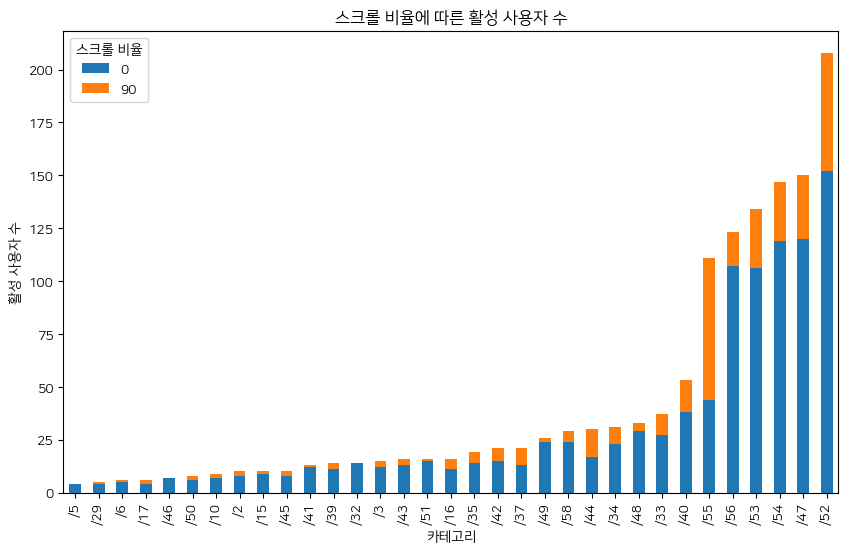

In [119]:
scroll_active_user_pivot = scroll_pure_active_user_df.pivot_table(index='경로', columns='스크롤 비율', values='활성 사용자', fill_value=0)
scroll_active_user_pivot["총합"] = scroll_active_user_pivot[0] + scroll_active_user_pivot[90]
scroll_active_user_pivot = scroll_active_user_pivot.sort_values(by='총합').drop(columns='총합')

ax = scroll_active_user_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('스크롤 비율에 따른 활성 사용자 수')
plt.xlabel('카테고리')
plt.ylabel('활성 사용자 수')
plt.legend(title='스크롤 비율')

plt.show()

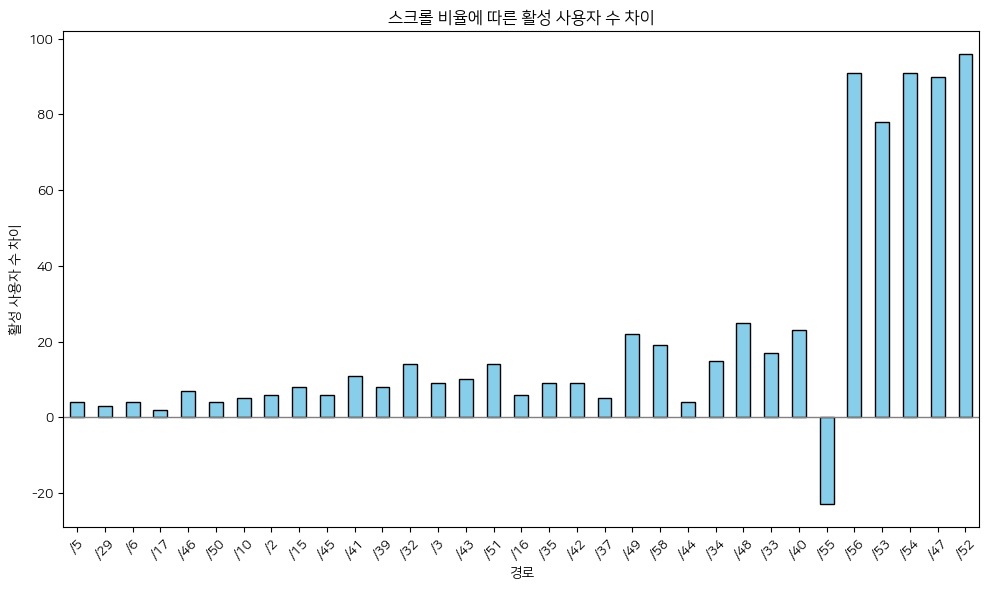

In [120]:
scroll_active_user_pivot['차이'] = scroll_active_user_pivot[0] - scroll_active_user_pivot[90]

ax = scroll_active_user_pivot['차이'].plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')

plt.title('스크롤 비율에 따른 활성 사용자 수 차이')
plt.xlabel('경로')
plt.ylabel('활성 사용자 수 차이')
plt.axhline(0, color='gray', linewidth=1)
plt.xticks(rotation=45)
plt.tight_layout() 

plt.show()

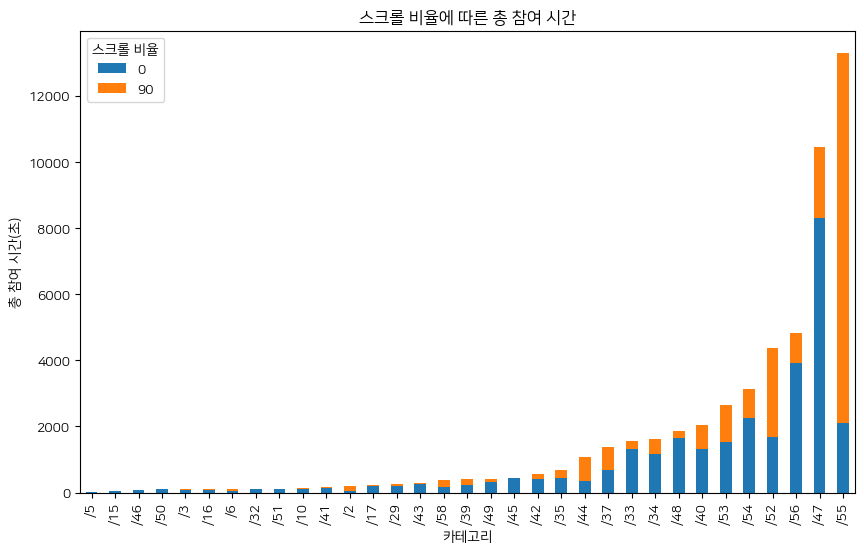

In [122]:
scroll_time_pivot = scroll_df.pivot_table(index='경로', columns='스크롤 비율', values='총 참여 시간', fill_value=0)
scroll_time_pivot["총합"] = scroll_time_pivot[0] + scroll_time_pivot[90]
scroll_time_pivot = scroll_time_pivot.sort_values(by='총합').drop(columns='총합')

ax = scroll_time_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('스크롤 비율에 따른 총 참여 시간')
plt.xlabel('카테고리')
plt.ylabel('총 참여 시간(초)')
plt.legend(title='스크롤 비율')

plt.show()

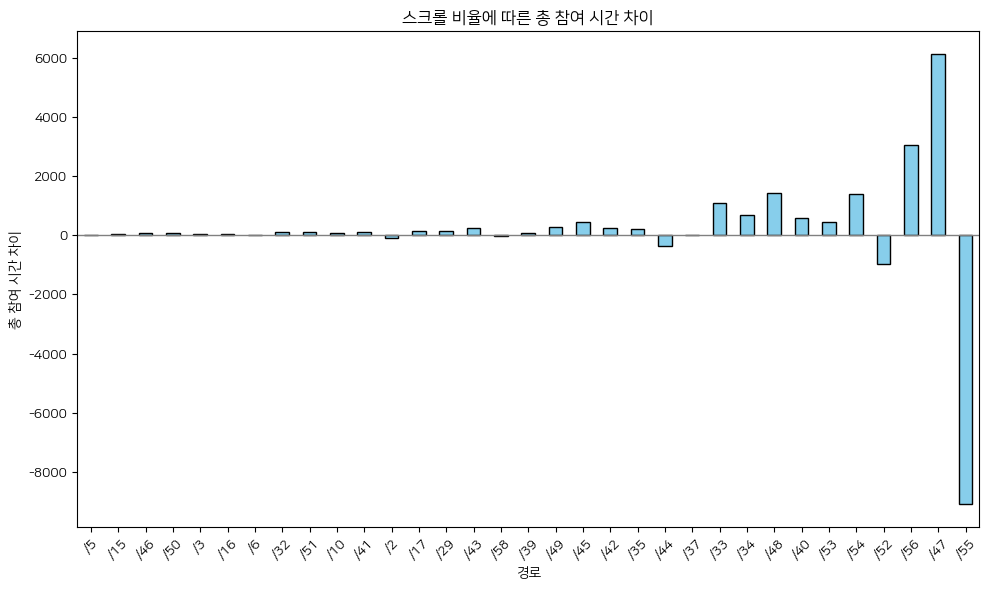

In [124]:
scroll_time_pivot['차이'] = scroll_time_pivot[0] - scroll_time_pivot[90]

ax = scroll_time_pivot['차이'].plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')

plt.title('스크롤 비율에 따른 총 참여 시간 차이')
plt.xlabel('경로')
plt.ylabel('총 참여 시간 차이')
plt.axhline(0, color='gray', linewidth=1)
plt.xticks(rotation=45)
plt.tight_layout() 

plt.show()

## **카테고리별**

In [127]:
scroll_df.head(5)

,카테고리,날짜,경로,스크롤 비율,총 참여 시간,활성 사용자
0,식당,2024-05-14 15:30:00,/58,90,191,5
1,식당,2024-05-14 15:30:00,/58,0,182,29
2,카페,2024-05-13 11:00:00,/56,0,3933,123
3,카페,2024-05-13 11:00:00,/56,90,880,16
4,문화생활,2024-05-08 11:20:00,/55,90,11200,67


In [137]:
scroll_category_df = scroll_df.groupby(["카테고리", "스크롤 비율"]).agg({"총 참여 시간":"sum", "활성 사용자":"sum"}).reset_index()
scroll_category_df

,카테고리,스크롤 비율,총 참여 시간,활성 사용자
0,공부,0,3099,114
1,공부,90,1444,34
2,문화생활,0,3032,166
3,문화생활,90,11676,78
4,식당,0,1921,112
5,식당,90,1019,24
6,정보,0,10342,204
7,정보,90,2546,40
8,제품,0,1527,76
9,제품,90,779,17


In [150]:
df.groupby("카테고리").agg({"활성 사용자":"sum", "총 참여 시간":"sum"})

,활성 사용자,총 참여 시간
카테고리,,
공부,118,4543
문화생활,168,14708
식당,113,2940
정보,210,12888
제품,78,2306
카페,688,15799


In [158]:
scroll_category_active_users_pivot = scroll_category_df.pivot(index='카테고리', columns='스크롤 비율', values='활성 사용자')
scroll_category_active_users_pivot[0] = scroll_category_active_users_pivot[0] - scroll_category_active_users_pivot[90]
scroll_category_active_users_pivot

스크롤 비율,0,90
카테고리,,
공부,80,34
문화생활,88,78
식당,88,24
정보,164,40
제품,59,17
카페,543,137


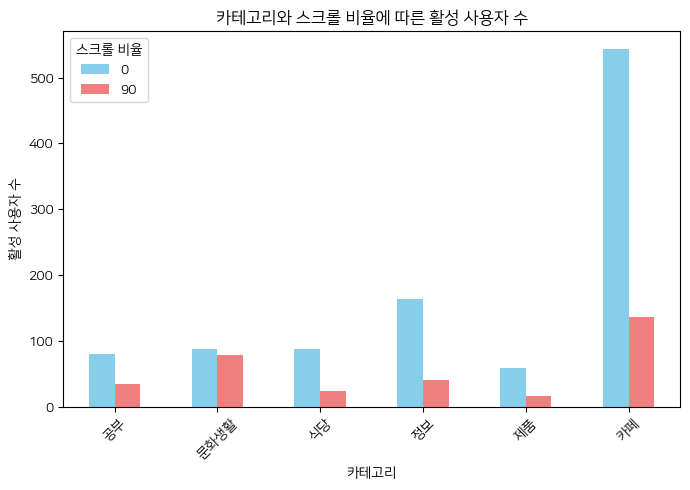

In [159]:
scroll_category_active_users_pivot.plot(kind='bar', figsize=(7, 5), color=['skyblue', 'lightcoral'])

plt.title('카테고리와 스크롤 비율에 따른 활성 사용자 수')
plt.xlabel('카테고리')
plt.ylabel('활성 사용자 수')
plt.legend(title='스크롤 비율')
plt.xticks(rotation=45)
plt.tight_layout() 

plt.show()

In [146]:
scroll_category_time_pivot = scroll_category_df.pivot(index='카테고리', columns='스크롤 비율', values='총 참여 시간')
scroll_category_time_pivot

스크롤 비율,0,90
카테고리,,
공부,3099,1444
문화생활,3032,11676
식당,1921,1019
정보,10342,2546
제품,1527,779
카페,10034,5765


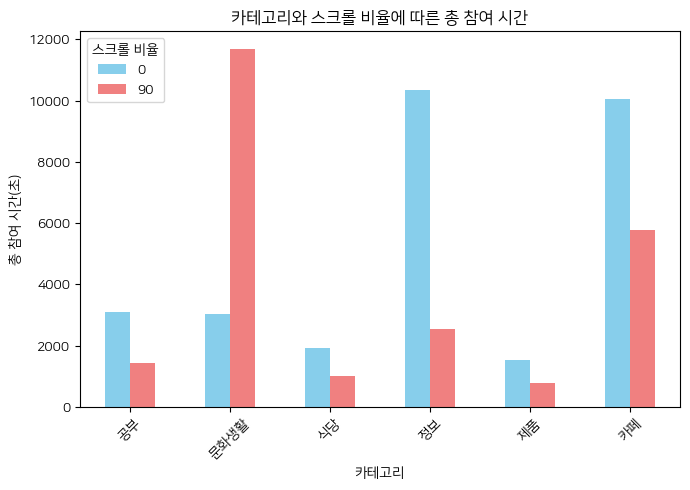

In [161]:
scroll_category_time_pivot.plot(kind='bar', figsize=(7, 5), color=['skyblue', 'lightcoral'])

plt.title('카테고리와 스크롤 비율에 따른 총 참여 시간')
plt.xlabel('카테고리')
plt.ylabel('총 참여 시간(초)')
plt.legend(title='스크롤 비율')
plt.xticks(rotation=45)
plt.tight_layout() 

plt.show()

# **페이지별**

In [165]:
category_df = remove_outliers_df.copy().groupby("카테고리").agg({"조회수" : "sum", "총 사용자 참여 시간" : "sum", "활성 사용자" : "sum", "참여 세션수" : "sum", "전체 세션수" : "sum"})
category_df["평균 참여 시간"] = (category_df["총 사용자 참여 시간"] / category_df["활성 사용자"]).apply(np.trunc)
category_df["평균 이탈률"] = ((1 - (category_df["참여 세션수"] / category_df["전체 세션수"])) * 100).round(2)
category_df

,조회수,총 사용자 참여 시간,활성 사용자,참여 세션수,전체 세션수,평균 참여 시간,평균 이탈률
카테고리,,,,,,,
공부,189,4543,114,81,126.0,39.0,35.71
문화생활,83,1404,55,43,63.0,25.0,31.75
식당,164,2940,112,76,128.0,26.0,40.62
정보,328,12888,204,134,235.0,63.0,42.98
제품,96,2306,76,56,81.0,30.0,30.86
카페,807,15816,682,382,725.0,23.0,47.31


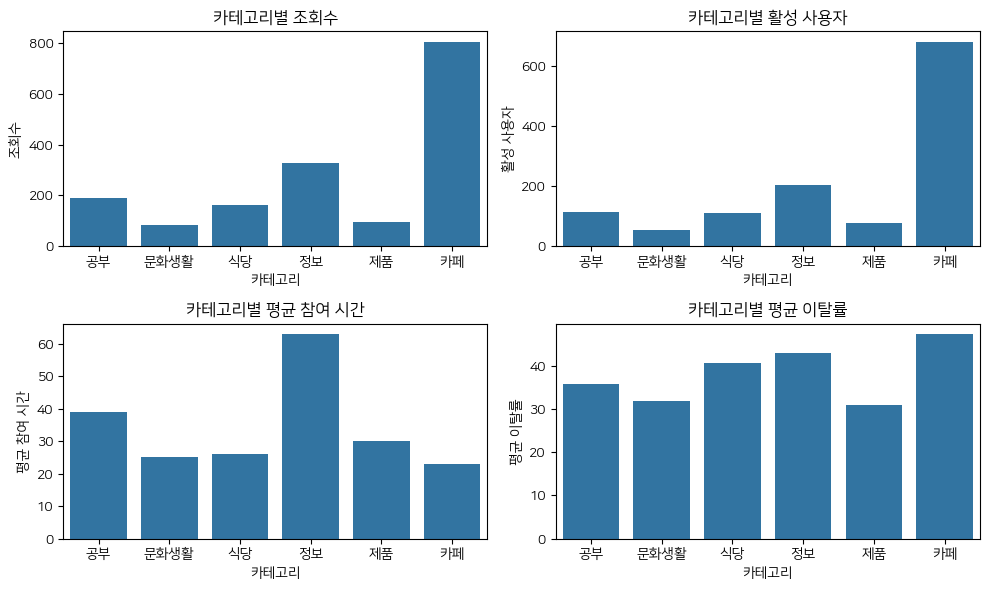

In [167]:
plt.figure(figsize=(10,6))

plt.subplot(2, 2, 1)
sns.barplot(x="카테고리", y="조회수", data=category_df)
plt.title('카테고리별 조회수')
plt.xlabel('카테고리')
plt.ylabel('조회수')

plt.subplot(2, 2, 2)
sns.barplot(x="카테고리", y="활성 사용자", data=category_df)
plt.title('카테고리별 활성 사용자')
plt.xlabel('카테고리')
plt.ylabel('활성 사용자')

plt.subplot(2, 2, 3)
sns.barplot(x="카테고리", y="평균 참여 시간", data=category_df)
plt.title('카테고리별 평균 참여 시간')
plt.xlabel('카테고리')
plt.ylabel('평균 참여 시간')

plt.subplot(2, 2, 4)
sns.barplot(x="카테고리", y="평균 이탈률", data=category_df)
plt.title('카테고리별 평균 이탈률')
plt.xlabel('카테고리')
plt.ylabel('평균 이탈률')

plt.tight_layout()
plt.savefig("./Data Project/save/카테고리별 지표.png", dpi=300)
plt.show()

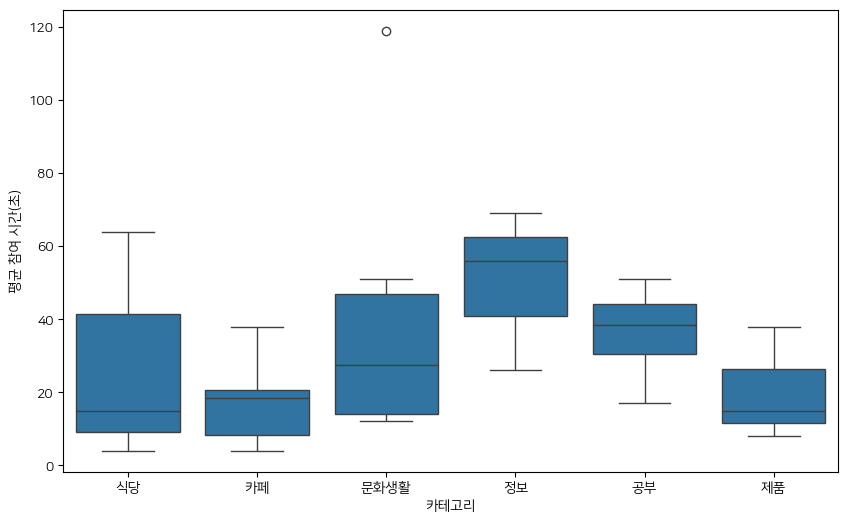

In [162]:
plt.figure(figsize=(10,6))
sns.boxplot(x="카테고리", y="평균 참여 시간(초)", data=df)
plt.show()

### **이상치 제거**
- 문화생활 부분 이상치 1개 제거

In [160]:
culture_data = df[df["카테고리"] == "문화생활"]["평균 참여 시간(초)"]

Q1 = culture_data.quantile(0.25)
Q3 = culture_data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

culture_data = culture_data[(culture_data < lower_bound) | (culture_data > upper_bound)]
culture_data.index

Index([2], dtype='int64')

In [151]:
remove_outliers_df = df.copy().drop(culture_data.index)
remove_outliers_df.head(5)

,카테고리,날짜,경로,이미지 수,gif 수,동영상 수,평균 데스크톱 LCP값,평균 데스크톱 SI값,평균 모바일 LCP값,평균 모바일 SI값,조회수,총 사용자 참여 시간,활성 사용자,참여율,참여 세션수,평균 참여 시간(초),전체 세션수
0,식당,2024-05-14 15:30:00,/58,11,1,0,14.52,3.88,77.4,12.90,39,373,29,0.322581,10,12.0,31.0
1,카페,2024-05-13 11:00:00,/56,8,0,0,6.60,3.00,50.3,10.70,138,4830,124,0.623077,81,38.0,130.0
3,카페,2024-05-06 14:07:00,/54,14,0,0,16.64,3.60,94.4,10.10,178,3124,148,0.518519,84,21.0,162.0
4,카페,2024-05-06 11:00:00,/53,24,0,0,13.40,4.50,69.7,11.00,150,2640,134,0.536232,74,19.0,138.0
5,카페,2024-05-03 11:00:00,/52,56,0,0,34.86,3.18,222.8,13.32,239,4366,208,0.441860,95,20.0,215.0


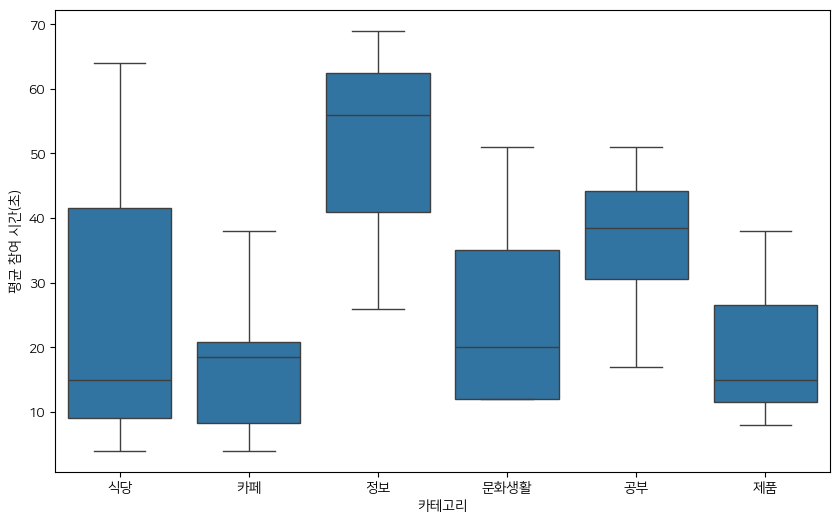

In [99]:
plt.figure(figsize=(10,6))
sns.boxplot(x="카테고리", y="평균 참여 시간(초)", data=remove_outliers_df)
plt.savefig("./Data Project/save/avg engagement time.png", dpi=300)
plt.show()

In [34]:
data_range = df[df["카테고리"] == "식당"]["평균 참여 시간(초)"]
Q1 = data_range.quantile(0.25)
Q2 = data_range.quantile(0.5)
Q3 = data_range.quantile(0.75)
min_value = data_range.min()
max_value = data_range.max()

print(f"Q1 (제 1사분위수): {Q1}")
print(f"Q2 (중앙값): {Q2}")
print(f"Q3 (제 3사분위수): {Q3}")
print(f"최소값: {min_value}")
print(f"최대값: {max_value}")

Q1 (제 1사분위수): 9.0
Q2 (중앙값): 15.0
Q3 (제 3사분위수): 41.5
최소값: 4.0
최대값: 64.0


In [69]:
start_date = '2024-03-01'
end_date = '2024-05-28'
dimensions = [Dimension(name="pagePath"), Dimension(name="deviceCategory")]
metrics=[Metric(name="screenPageViews"), Metric(name="userEngagementDuration"), Metric(name="activeUsers"), Metric(name="engagementRate"), Metric(name="engagedSessions")]

In [70]:
response = run_report(start_date, end_date, dimensions, metrics)
devices_df = convert_to_dataframe(response)
devices_df.head(5)

,pagePath,deviceCategory,screenPageViews,userEngagementDuration,activeUsers,engagementRate,engagedSessions
0,/52,mobile,196,3561,180,0.40331491712707185,73
1,/54,mobile,138,2466,120,0.52272727272727271,69
2,/47,desktop,135,8374,77,0.51086956521739135,47
3,/53,mobile,124,1975,116,0.50420168067226889,60
4,/47,mobile,112,2051,73,0.61627906976744184,53


In [71]:
devices_df = devices_df.rename(columns = {"deviceCategory" : "디바이스 종류", "screenPageViews" : "조회수", "userEngagementDuration" : "총 사용자 참여 시간", 
                          "activeUsers" : "활성 사용자", "engagementRate" : "참여율", "engagedSessions" : "참여 세션수"})

In [72]:
devices_df = devices_df.astype({'총 사용자 참여 시간':'int', '활성 사용자':'int', '참여율':'float', '참여 세션수' : 'int'})

In [73]:
devices_df["평균 참여 시간(초)"] = (devices_df["총 사용자 참여 시간"] / devices_df["활성 사용자"]).apply(np.trunc)

In [74]:
devices_df.head(5)

,pagePath,디바이스 종류,조회수,총 사용자 참여 시간,활성 사용자,참여율,참여 세션수,평균 참여 시간(초)
0,/52,mobile,196,3561,180,0.403315,73,19.0
1,/54,mobile,138,2466,120,0.522727,69,20.0
2,/47,desktop,135,8374,77,0.510870,47,108.0
3,/53,mobile,124,1975,116,0.504202,60,17.0
4,/47,mobile,112,2051,73,0.616279,53,28.0


In [76]:
mobile_devices_df = devices_df[devices_df["디바이스 종류"] == "mobile"]
mobile_devices_df.head(5)

,pagePath,디바이스 종류,조회수,총 사용자 참여 시간,활성 사용자,참여율,참여 세션수,평균 참여 시간(초)
0,/52,mobile,196,3561,180,0.403315,73,19.0
1,/54,mobile,138,2466,120,0.522727,69,20.0
3,/53,mobile,124,1975,116,0.504202,60,17.0
4,/47,mobile,112,2051,73,0.616279,53,28.0
5,/56,mobile,112,3712,106,0.612613,68,35.0


In [83]:
test_path = mobile_devices_df.sort_values(["활성 사용자", "참여율", "평균 참여 시간(초)"], ascending=[False, True, True])[:15]["pagePath"].to_list()
test_path

['/52',
 '/54',
 '/53',
 '/56',
 '/47',
 '/55',
 '/40',
 '/58',
 '/48',
 '/33',
 '/49',
 '/44',
 '/16',
 '/51',
 '/34']

## **PageSpeed**

- Largest Contentful Paint (LCP) : 표시 영역에서 가장 큰 콘텐츠 요소가 화면에 렌더링될 때 측정되는 시간
- Speed Index (SI) : 페이지 로드 중 콘텐츠가 시각적으로 표시되는 속도

In [5]:
page_url = df['경로'].unique()

In [46]:
page_speed_url = "https://www.googleapis.com/pagespeedonline/v5/runPagespeed"

speed_data = []
for path in page_url:
    url = BLOG_URL + path

    desktop_LCP_values = []
    desktop_SI_values = [] 
    mobile_LCP_values = []
    mobile_SI_values = []

    for _ in range(5):
        desktop_params = {
            "url" : url,
            "strategy" : "desktop",
            "key" : GOOGLE_PAGE_SPEED_API_KEY
        }
        
        mobile_params = {
            "url" : url,
            "strategy" : "mobile",
            "key" : GOOGLE_PAGE_SPEED_API_KEY
        }
    
        desktop_response = requests.get(page_speed_url, desktop_params)
        mobile_response = requests.get(page_speed_url, mobile_params)
    
        desktop_LCP = float(desktop_response.json()["lighthouseResult"]["audits"]['largest-contentful-paint']['displayValue'].replace('\xa0s', ''))
        desktop_SI = float(desktop_response.json()["lighthouseResult"]["audits"]['speed-index']['displayValue'].replace('\xa0s', ''))
        
        mobile_LCP = float(mobile_response.json()["lighthouseResult"]["audits"]['largest-contentful-paint']['displayValue'].replace('\xa0s', ''))
        mobile_SI = float(mobile_response.json()["lighthouseResult"]["audits"]['speed-index']['displayValue'].replace('\xa0s', ''))

        desktop_LCP_values.append(desktop_LCP)
        desktop_SI_values.append(desktop_SI)
        mobile_LCP_values.append(mobile_LCP)
        mobile_SI_values.append(mobile_SI)

    avg_desktop_LCP = np.mean(desktop_LCP_values)
    avg_desktop_SI = np.mean(desktop_SI_values)
    avg_mobile_LCP = np.mean(mobile_LCP_values)
    avg_mobile_SI = np.mean(mobile_SI_values)

    speed_data.append([path, avg_desktop_LCP, avg_desktop_SI, avg_mobile_LCP, avg_mobile_SI])    

In [256]:
speed_df = pd.DataFrame(speed_data, columns=["경로", "평균 데스크톱 LCP값", "평균 데스크톱 SI값", "평균 모바일 LCP값" , "평균 모바일 SI값"])
speed_df.head(5)

,경로,평균 데스크톱 LCP값,평균 데스크톱 SI값,평균 모바일 LCP값,평균 모바일 SI값
0,/58,14.52,3.88,77.4,12.9
1,/56,6.60,3.00,50.3,10.7
2,/55,17.46,4.84,96.1,16.7
3,/54,16.64,3.60,94.4,10.1
4,/53,13.40,4.50,69.7,11.0


In [254]:
speed_df.to_csv('./Data Project/Data/Tistory_posts_speed.csv', index=False)

In [257]:
speed_df = pd.read_csv('./Data Project/Data/Tistory_posts_speed.csv')
speed_df.head(5)

,경로,평균 데스크톱 LCP값,평균 데스크톱 SI값,평균 모바일 LCP값,평균 모바일 SI값
0,/58,14.52,3.88,77.4,12.9
1,/56,6.60,3.00,50.3,10.7
2,/55,17.46,4.84,96.1,16.7
3,/54,16.64,3.60,94.4,10.1
4,/53,13.40,4.50,69.7,11.0


In [54]:
df = df.merge(speed_df, on="경로")

In [90]:
avg_device_speed_df = df[['평균 데스크톱 LCP값', '평균 데스크톱 SI값', '평균 모바일 LCP값', '평균 모바일 SI값']].mean().reset_index().rename(columns={"index": "지표", 0: "평균값"})
avg_device_speed_df = avg_device_speed_df.set_index('지표').T
avg_device_speed_df

지표,평균 데스크톱 LCP값,평균 데스크톱 SI값,평균 모바일 LCP값,평균 모바일 SI값
평균값,14.835152,3.569091,89.549091,13.106061


In [92]:
avg_device_speed_df['평균 데스크톱 LCP값']["평균값"]

14.835151515151516

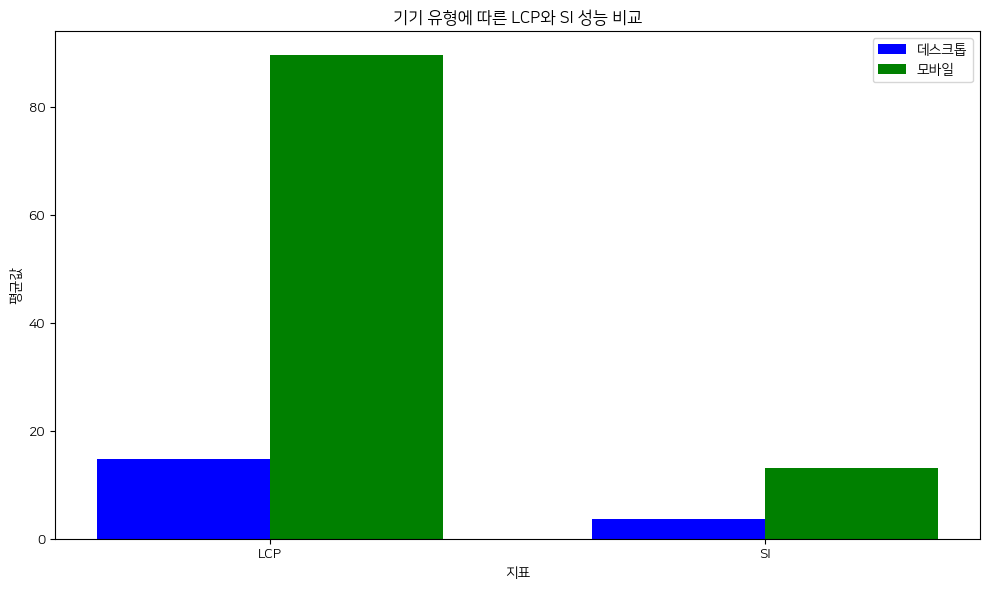

In [100]:
desktop_lcp = avg_device_speed_df['평균 데스크톱 LCP값']["평균값"]
mobile_lcp = avg_device_speed_df['평균 모바일 LCP값']["평균값"]
desktop_si = avg_device_speed_df['평균 데스크톱 SI값']["평균값"]
mobile_si = avg_device_speed_df['평균 모바일 SI값']["평균값"]

labels = ['LCP', 'SI']
desktop_values = [desktop_lcp, desktop_si]
mobile_values = [mobile_lcp, mobile_si]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, desktop_values, width, label='데스크톱', color='blue')
ax.bar([p + width for p in x], mobile_values, width, label='모바일', color='green')

ax.set_xlabel('지표')
ax.set_ylabel('평균값')
ax.set_title('기기 유형에 따른 LCP와 SI 성능 비교')
ax.set_xticks([p + width/2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.savefig("./Data Project/save/기기 유형에 따른 LCP와 SI 성능 비교.png", dpi=300)
plt.show()

In [39]:
pagespeed_df = df.groupby(["카테고리"]).agg({"평균 데스크톱 LCP값" : "mean", "평균 데스크톱 SI값" : "mean", "평균 모바일 LCP값" : "mean", "평균 모바일 SI값" : "mean"})

In [105]:
pagespeed_df

,평균 데스크톱 LCP값,평균 데스크톱 SI값,평균 모바일 LCP값,평균 모바일 SI값
카테고리,,,,
공부,6.075000,3.475000,41.200000,12.825000
문화생활,20.843333,3.600000,127.816667,14.150000
식당,12.722857,3.708571,73.214286,13.820000
정보,9.733333,3.233333,57.000000,12.700000
제품,11.700000,3.666667,63.800000,12.766667
카페,18.684000,3.562000,114.852000,12.316000


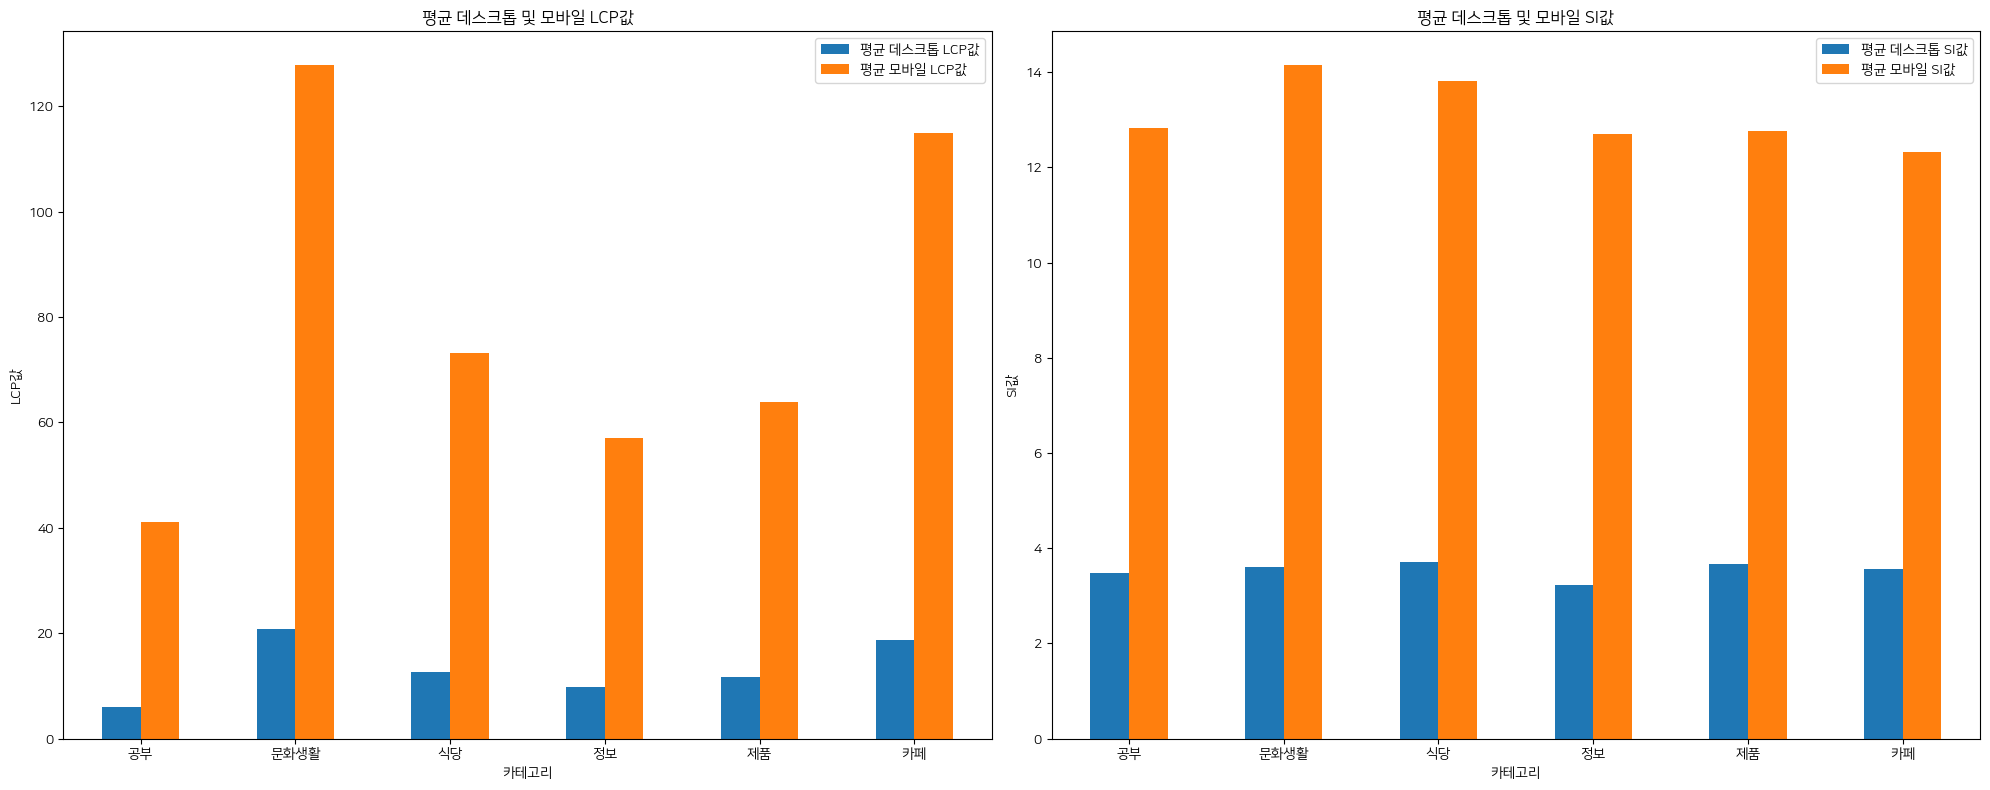

In [240]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))


pagespeed_df.reset_index().plot(kind='bar', x='카테고리', y=['평균 데스크톱 LCP값', '평균 모바일 LCP값'], ax=ax[0])
ax[0].set_title('평균 데스크톱 및 모바일 LCP값')
ax[0].set_ylabel('LCP값')
ax[0].set_xlabel('카테고리')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation='horizontal')

pagespeed_df.reset_index().plot(kind='bar', x='카테고리', y=['평균 데스크톱 SI값', '평균 모바일 SI값'], ax=ax[1])
ax[1].set_title('평균 데스크톱 및 모바일 SI값')
ax[1].set_ylabel('SI값')
ax[1].set_xlabel('카테고리')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation='horizontal')

plt.tight_layout()
plt.savefig("./Data Project/save/평균 데스크톱 및 모바일 lcp와 si.png", dpi=300)
plt.show()

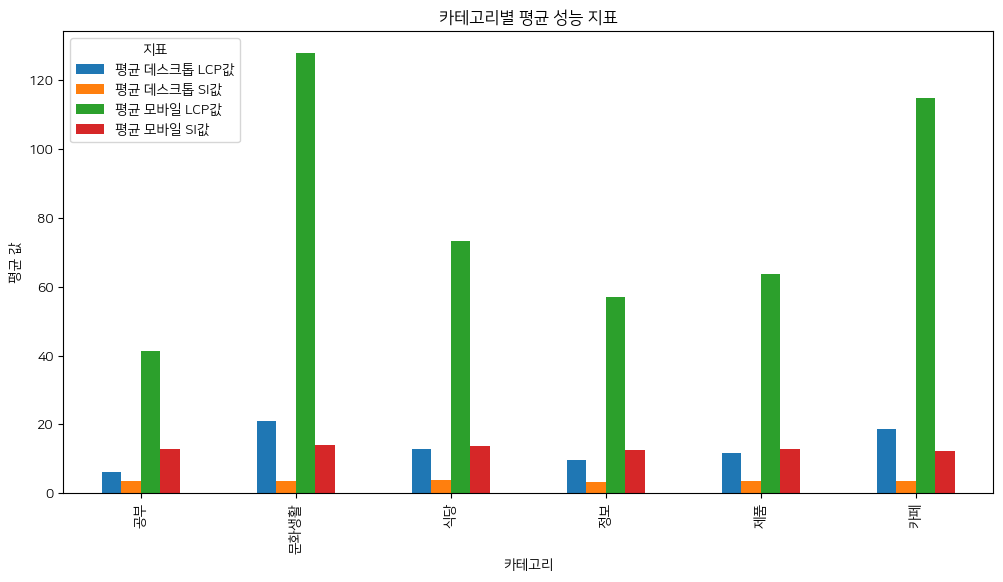

In [66]:
result.plot(kind="bar", figsize=(12, 6))

plt.title("카테고리별 평균 성능 지표")
plt.xlabel("카테고리")
plt.ylabel("평균 값")

plt.legend(title="지표")
plt.show()

In [113]:
df.to_csv('./Data Project/Data/산점도 체크.csv', index=False)

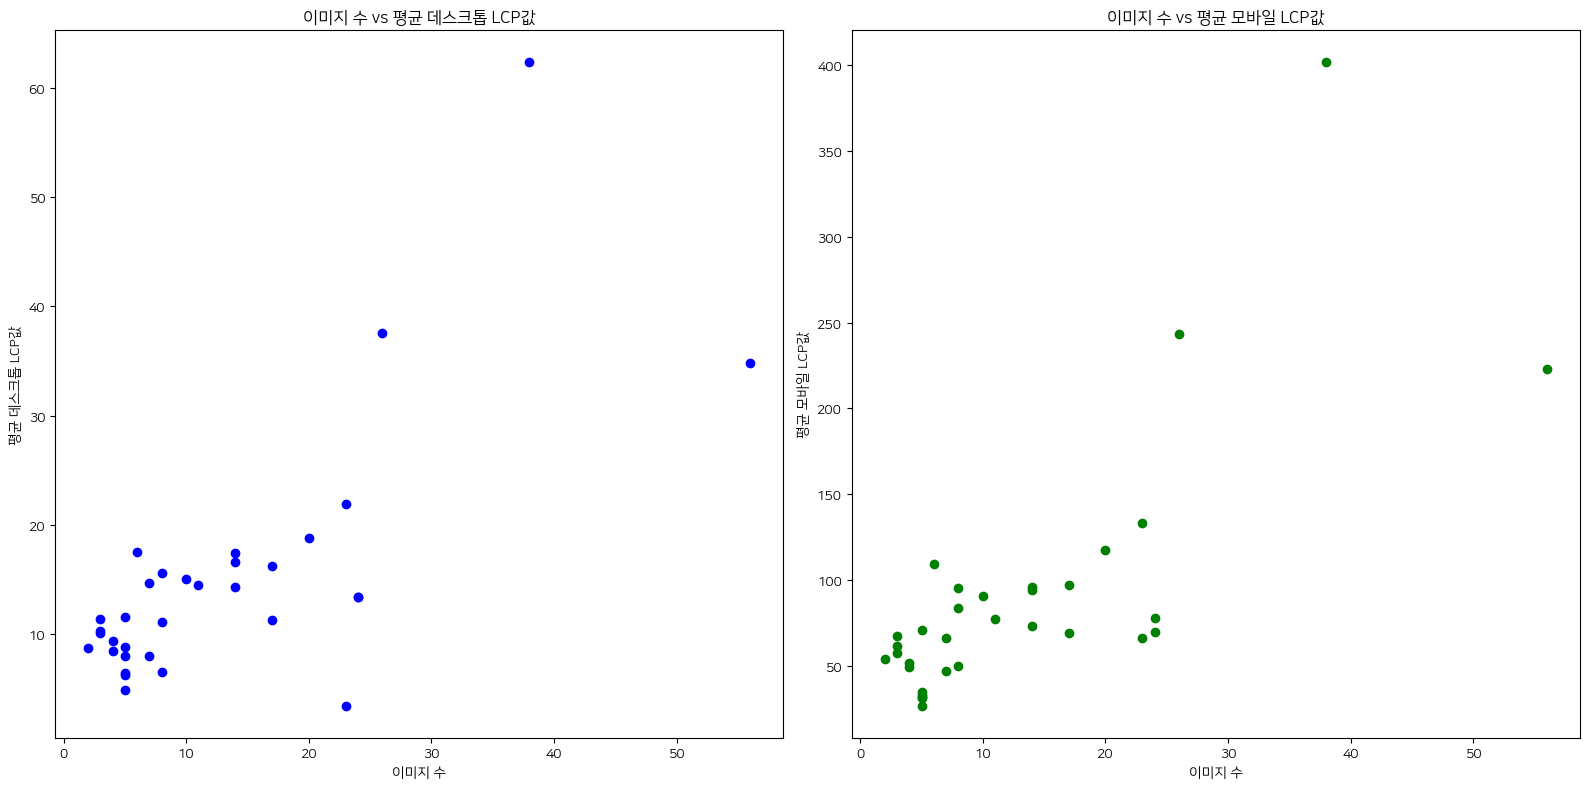

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# 평균 데스크톱 LCP값과 이미지 개수
ax[0].scatter(df['이미지 수'], df['평균 데스크톱 LCP값'], color='blue')
ax[0].set_title('이미지 수 vs 평균 데스크톱 LCP값')
ax[0].set_xlabel('이미지 수')
ax[0].set_ylabel('평균 데스크톱 LCP값')

# 평균 모바일 LCP값과 이미지 개수
ax[1].scatter(df['이미지 수'], df['평균 모바일 LCP값'], color='green')
ax[1].set_title('이미지 수 vs 평균 모바일 LCP값')
ax[1].set_xlabel('이미지 수')
ax[1].set_ylabel('평균 모바일 LCP값')

plt.tight_layout()
plt.show()

In [ ]:
page_speed_url = "https://www.googleapis.com/pagespeedonline/v5/runPagespeed"

speed_data = []
for path in page_url[:1]:
    url = BLOG_URL + path
    print(url)

    desktop_LCP_values = []
    desktop_SI_values = [] 
    mobile_LCP_values = []
    mobile_SI_values = []

    desktop_params = {
        "url" : url,
        "strategy" : "desktop",
        "key" : GOOGLE_PAGE_SPEED_API_KEY
    }
    
    mobile_params = {
        "url" : url,
        "strategy" : "mobile",
        "key" : GOOGLE_PAGE_SPEED_API_KEY
    }

    desktop_response = requests.get(page_speed_url, desktop_params)
    mobile_response = requests.get(page_speed_url, mobile_params)

    data = mobile_response.json()

    optimized_images = data["lighthouseResult"]["audits"]["uses-optimized-images"]["details"]["items"]

    total_sum = 0
    for image in optimized_images:

        total_sum += image["totalBytes"]
    print(total_sum)
    print(data["lighthouseResult"]["audits"]["resource-summary"]["details"]["items"])

In [37]:
print(total_sum)

10096038


In [ ]:
print(json.dumps(data, ensure_ascii=False, indent=3))

# **요일별, 시간대별**

In [53]:
DAY_NAME_MAP = {
    'Monday': '월',
    'Tuesday': '화',
    'Wednesday': '수',
    'Thursday': '목',
    'Friday': '금',
    'Saturday': '토',
    'Sunday': '일'
}

In [50]:
visiting_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   경로       1201 non-null   object        
 1   방문날짜시간   1201 non-null   object        
 2   조회수      1201 non-null   int32         
 3   총 참여 시간  1201 non-null   int32         
 4   활성 사용자   1201 non-null   int32         
 5   참여율      1201 non-null   float64       
 6   참여 세션수   1201 non-null   int32         
 7   방문날짜     1201 non-null   datetime64[ns]
 8   방문시간     1201 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(5), object(2)
memory usage: 61.1+ KB


In [54]:
visiting_time_df["방문요일"] = visiting_time_df["방문날짜"].dt.day_name().map(DAY_NAME_MAP)

In [56]:
day_df = visiting_time_df.groupby(["방문요일"]).agg({"총 참여 시간":"sum", "활성 사용자":"sum", "조회수":"sum"})
day_df["평균 참여 시간"] = day_df["총 참여 시간"] / day_df["활성 사용자"]
day_df = day_df.reindex(list("월화수목금토일"))
day_df["사용자당 조회수"] = day_df["조회수"] / day_df["활성 사용자"]
day_df

,총 참여 시간,활성 사용자,조회수,평균 참여 시간,사용자당 조회수
방문요일,,,,,
월,10353,333,405,31.090090,1.216216
화,5214,163,188,31.987730,1.153374
수,11967,226,253,52.951327,1.119469
목,7088,203,225,34.916256,1.108374
금,6483,166,240,39.054217,1.445783
토,6262,219,271,28.593607,1.237443
일,6145,234,289,26.260684,1.235043


<Figure size 1000x600 with 0 Axes>

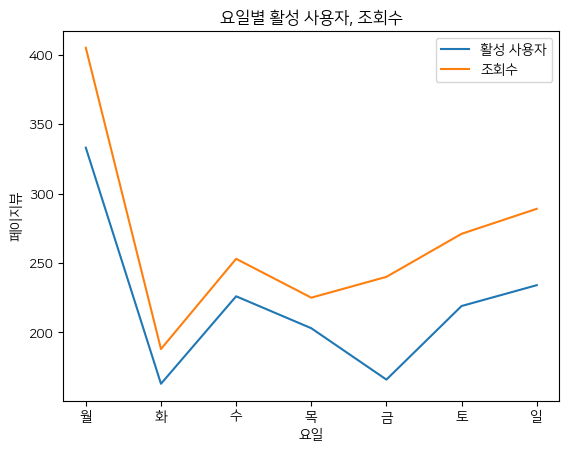

In [57]:
plt.figure(figsize=(10, 6))
day_df[["활성 사용자", "조회수"]].plot(kind='line', title='요일별 활성 사용자, 조회수')
plt.xlabel('요일')
plt.ylabel('페이지뷰')
plt.savefig("./Data Project/save/요일별 활성 사용자, 조회수.png", dpi=300)
plt.show()

In [59]:
hour_df = visiting_time_df.groupby(["방문시간"]).agg({"조회수" : "sum", "총 참여 시간":"sum", "활성 사용자":"sum"})
hour_df["평균 참여 시간"] = hour_df["총 참여 시간"] / hour_df["활성 사용자"]

In [60]:
hour_df = hour_df.reset_index()

<Figure size 1000x600 with 0 Axes>

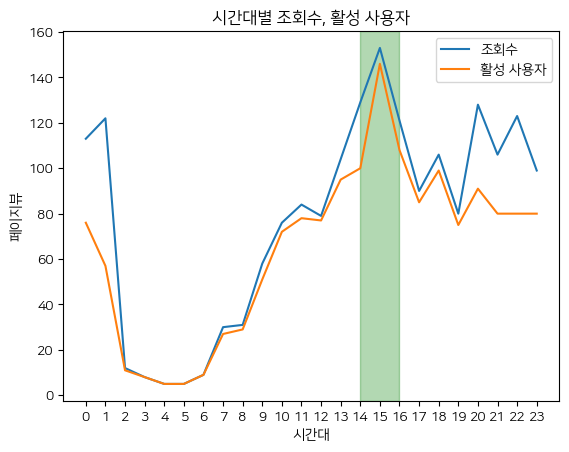

In [61]:
plt.figure(figsize=(10, 6))
hour_df[["조회수", "활성 사용자"]].plot(kind='line', title='시간대별 조회수, 활성 사용자')
plt.xlabel('시간대')
plt.ylabel('페이지뷰')
plt.xticks(range(len(hour_df['방문시간'])), hour_df['방문시간'])
plt.axvspan(14, 16, color='green', alpha=0.3)
plt.savefig("./Data Project/save/시간대별 조회수, 활성 사용자.png", dpi=300)
plt.show()

In [62]:
average_visitors_by_hour = hour_df.groupby('방문시간')['활성 사용자'].mean().reset_index()

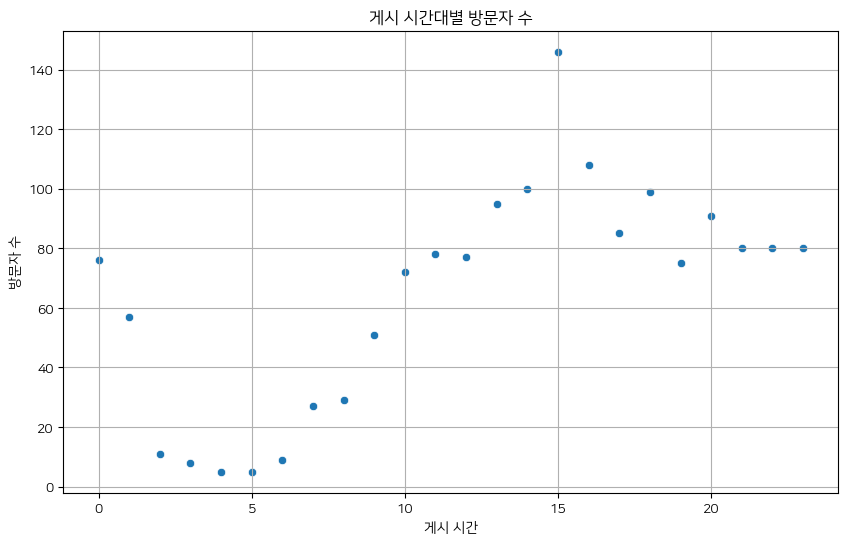

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='방문시간', y='활성 사용자', data=average_visitors_by_hour)
plt.title('게시 시간대별 방문자 수')
plt.xlabel('게시 시간')
plt.ylabel('방문자 수')
plt.grid(True)
plt.show()

In [355]:
category_hour_df = df.groupby(["카테고리", "방문시간"]).agg({"조회수" : "sum", "총 사용자 참여 시간":"sum", "활성 사용자":"sum"})
category_hour_df["평균 참여 시간"] = category_hour_df["총 사용자 참여 시간"] / category_hour_df["활성 사용자"]
category_hour_df = category_hour_df.reset_index()

In [377]:
category_hour_df.to_csv('./Data Project/Data/Tistory_posts_category_hour.csv', index=False)

In [382]:
category_hour_df.columns

Index(['카테고리', '방문시간', '조회수', '총 사용자 참여 시간', '활성 사용자', '평균 참여 시간'], dtype='object')

In [391]:
category_hour_df = category_hour_df.sort_values(by=["카테고리", '방문시간'], ascending=True)

In [396]:
full_hours = pd.DataFrame({'방문시간': np.arange(24)})

In [392]:
category_hour_df

,카테고리,방문시간,조회수,총 사용자 참여 시간,활성 사용자,평균 참여 시간
0,공부,00,19,299,6,49.833333
1,공부,01,20,507,8,63.375000
2,공부,02,1,112,1,112.000000
3,공부,04,1,0,1,0.000000
4,공부,05,1,0,1,0.000000
...,...,...,...,...,...,...
122,카페,19,33,326,33,9.878788
123,카페,20,43,774,33,23.454545
124,카페,21,32,387,31,12.483871
125,카페,22,42,518,37,14.000000


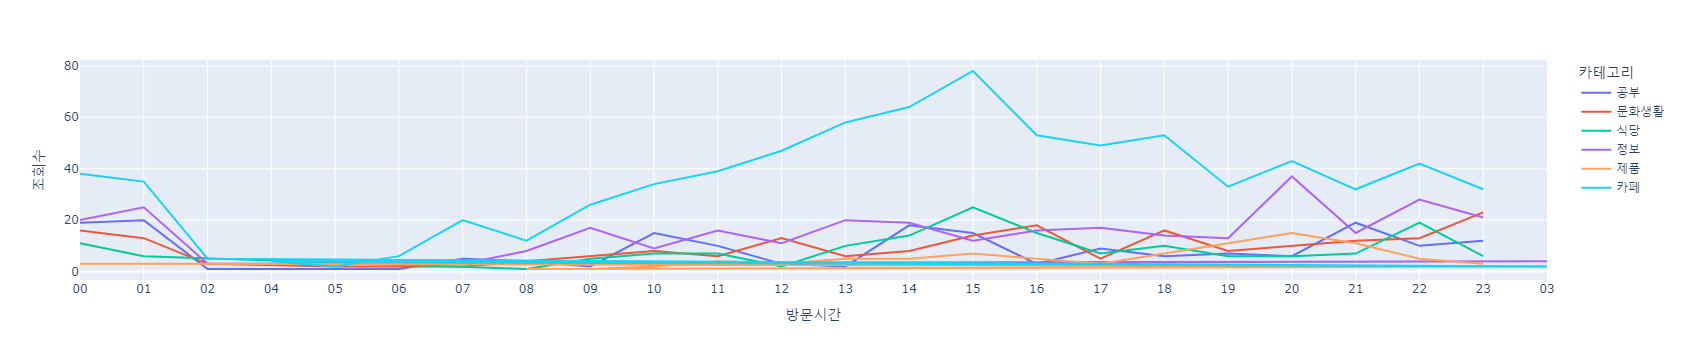

In [393]:
fig = px.line(category_hour_df, x="방문시간", y="조회수", color="카테고리")
fig.show()

In [117]:
df

,카테고리,날짜,경로,이미지 수,gif 수,동영상 수,평균 데스크톱 LCP값,평균 데스크톱 SI값,평균 모바일 LCP값,평균 모바일 SI값,조회수,총 사용자 참여 시간,활성 사용자,참여율,참여 세션수,평균 참여 시간(초),전체 세션수
0,식당,2024-05-14 15:30:00,/58,11,1,0,14.52,3.88,77.40,12.90,39,373,29,0.322581,10,12.0,31.0
1,카페,2024-05-13 11:00:00,/56,8,0,0,6.60,3.00,50.30,10.70,138,4830,124,0.623077,81,38.0,130.0
2,문화생활,2024-05-08 11:20:00,/55,14,0,0,17.46,4.84,96.10,16.70,125,13304,111,0.743590,87,119.0,117.0
3,카페,2024-05-06 14:07:00,/54,14,0,0,16.64,3.60,94.40,10.10,178,3124,148,0.518519,84,21.0,162.0
4,카페,2024-05-06 11:00:00,/53,24,0,0,13.40,4.50,69.70,11.00,150,2640,134,0.536232,74,19.0,138.0
5,카페,2024-05-03 11:00:00,/52,56,0,0,34.86,3.18,222.80,13.32,239,4366,208,0.441860,95,20.0,215.0
6,정보,2024-04-29 13:00:00,/48,7,0,0,8.00,3.70,46.90,10.00,40,1876,33,0.617647,21,56.0,34.0
7,카페,2024-04-27 11:00:00,/51,8,0,0,15.60,3.40,95.60,13.40,20,116,16,0.312500,5,7.0,16.0
8,식당,2024-04-26 11:00:00,/45,14,0,0,14.30,4.00,73.10,13.80,16,455,10,0.666667,8,45.0,12.0
9,문화생활,2024-04-26 10:00:00,/50,3,0,0,11.40,3.80,67.70,17.60,12,98,8,0.600000,6,12.0,10.0
